In [1]:
# author: Carlos F. Dietrich (carlos.dietrich@tum.de)
# reviewer: Francisco J. Guerrero-Gonzalez
# version: 1.1.0

Copyright 2023, Professorship of Lunar and Planetary Exploration, Technical University of Munich.

Permission is hereby granted, free of charge, to any person obtaining a copy of this model and associated documentation files, without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the models, and to permit persons to whom the model is furnished to do so, subject to the following conditions:

1. The above copyright notice and this permission notice shall be included in all copies or substantial portions of the model, as well as reference to the author(s) listed above. Scientific publications which use this model shall cite the [ISRULib documentation site](https://wiki.tum.de/display/lpe/ISRULib) attributing credit to the named authors in the documentation.

2. The model is provided without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose, and non-infringement. In no event shall the authors or copyright holders be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the model or the use or other dealings in the model.


# RASSOR Excavator

In [2]:
# Python Libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from prettytable import PrettyTable

**Model Description**

This excavator model is based on NASA’s Regolith Advanced Surface Systems Operations Robot (RASSOR). RASSOR includes two sets of bucket drums that produce opposing digging forces, causing a net-zero horizontal reaction force and enabling its operation under reduced lunar gravity. RASSOR can drop the feedstock by reversing the rotation direction of the bucket drums.

The 67-kg excavator vehicle has a payload capacity of 90 kg (Schuler et al., 2019). Further sources that describe RASSOR's behavior are Mueller et al. (2016) and Schuler et al. (2023).

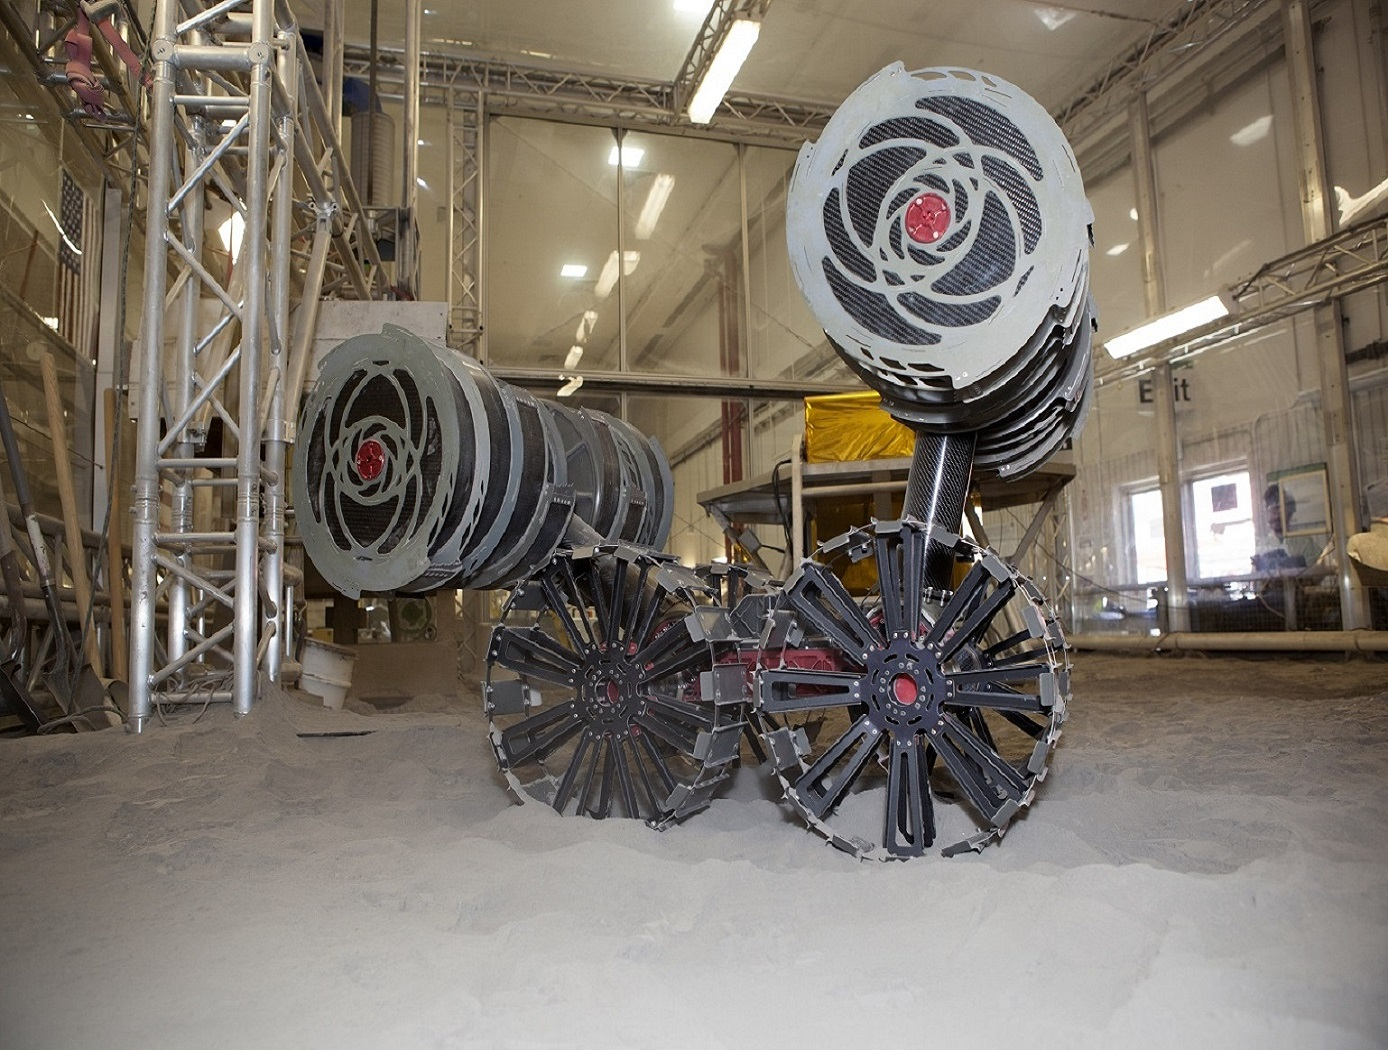

In [3]:
# Include here a descriptive figure of the component (model)
display.Image("figs/rassor.jpg")

**Model Assumptions, Simplifications and future Improvements**

The model computes two operating modes for RASSOR.

1. The first operating mode describes the process of mining at one location, e.g., in a permanently shadowed region (PSR), to excavate icy regolith. The process flow begins with the excavator starting at the ISRU production plant and transporting waste material to a disposal site located 100 m away from the ISRU production plant. In the next step, the vehicle would drive 100 m from the disposal site to the excavation site. There, RASSOR would excavate regolith until the bucket drums are filled. Subsequently, the rover drives 100 m to the base, where it unloads the mined ore into the ISRU production plant. Then the cycle would repeat until the batteries need to be charged at the base. As an approximation, the time required to collect and dump the waste material is assumed the same as for fresh regolith.

2. The second operation mode assumes that RASSOR travels further with increasing time. This factor is included as excavating deeper layers becomes progressively difficult with the rising density of the regolith. With increasing mission duration, RASSOR excavates less material, but it is also expected that the complexity of the route will increase. Hence, a linear increase in distance is assumed. The operating flow is the same as in the first procedure, with the difference that the driving distance to the disposal site and the distance between the excavation site and ISRU production plant increases each day. Additionally, the distance between the disposal and excavation sites also increases each day, as it is assumed the three sites are constellated in a triangle and not always the direct path can be traveled. Therefore, if a 4 m wide and a 4 m deep trench is excavated, the additional length per day can be calculated using the initial excavated volume from Mode 1. It is assumed that RASSOR can mine the material in 4 m depth by excavating layer by layer. Also, the operation is split into days (24h) to receive the daily modeled values.

The time calculation for the routes follow these assumptions:
1. Collecting waste at the ISRU plant, driving to disposal site and dumping waste.
2. Driving to excavation site and excavating.
3. Driving to ISRU plant and dumping fresh regolith.

The driving speed is considered to be constant. No time for slowing down for steering or parking is considered. The base values for RASSOR are based on Schuler et al. (2019) and Schuler et al. (2023), and are listed in **1. Inputs**. 

The empty mass of the rover is estimated by adding the mass of a radiator to the mass stated in the literature. 
The mass for theadiator is estimated with a required mass per heat rejection factor (kg/kW). The value is a rough approximation from Anderson et al. (2017) for lightweight lunar radiators. The full mass of the rover is the empty mass of the rover added to the max. regolith capacity stated in the literature. No further masses are considered.

The maximum excavation power is calculated by the motor RPM and torque. The average excavation power is assumed to be 75% of the max. excavation power as the density of the regolith increases with increasing time. However, in Mode 2, the rover will also drive further to excavate the top layer. Furthermore, when the bucket wheel is filling, the required power is increasing. Hence, 75% is selected. The power for the empty and full driving is calculated similat to Linne et al. (2021). The required power for dumping the regolith is calculated by assuming the normal torque and RPM stated for the actuators. 

Cooling estimation assumes a motor efficency of 50% (Linne et al. 2021); and that the avionics require 100% cooling.

It is assumed that the battery has a usable share of 80% due to assumed min. SOC of 10% and max. SOC of 90%. 

Future improvements could include:
- A more detailed power consumption estimation.
- A more detailed mining rate estimation.
- Including the factor of increasing desity with increasing depth. This could lead to a higher power requirement.
- Include more detailed process of handling the waste from ISRU plant.
- Adapt the operation modus to individual needs. E.g., assume a different operating model than the 24 operation times. 

The rest of the assumptions and possible improvements are explained thoroughly in **3. Model Body**

## 1. Inputs

In [4]:
# Assumptions for start-distances between sites:
DistanceISRU2Excavation     = 100 # m | Distance between ISRU production plant and excavation site
DistanceISRU2Disposal       = 100 # m | Distance between ISRU production plant and disposal site
DistanceDisposal2Excavation = 100 # m | Distance between disposal site and excavation site

# RASSOR technical data:
BatteryCapacityNormal = 1410 # Wh | Battery capacity (Schuler et al., 2019)
DrivingSpeed          = 0.49 # m/s | Drive speed of rover (Schuler et al., 2019)
RegolithCapacity      = 90 # kg | Payload capacity (Schuler et al., 2019)
MassEmpty             = 67 # kg | Empty mass of excavator (Schuler et al., 2019)
PowerComputer         = 21 # W | Power consumed by onboard computer (Mueller et al., 2016), e.g., https://www.rtd.com/IDAN/CM/CMX32/IDAN-CMX32MVD.htm
PowerRadio            = 8 # W | Power consumed by onboard radio (Mueller et al., 2016), e.g., https://dl.ubnt.com/datasheets/picostationm/picom2hp_DS.pdf

RollingResistanceEmpty = 0.25 # - | Rolling restiance for empty excavator. Assumption adapted from Linne et al. (2021)
RollingResistanceFull  = 0.28 # - | Rolling restiance for full excavator. Assumption adapted from Linne et al. (2021)
MotorEfficiency        = 0.5 # - | Efficiency of Motor for driving. Assumption adapted from Linne et al. (2021)

ExcavationRate = 4*0.27*0.75 # kg/s | Excavation rate for 4 drums, a collection Rate for large drum, 25 mm cut, 20 mm/s, and adding efficiency of 75% (Schuler et al., 2023)
DumpRate       = 4*1.50*0.75 # kg/s | Dumping rate (Schuler et al. 2023, assumption from time to dump displayed in Fig. 12, adding efficiency of 75%)

ChargingRate       = 200 # W | Charging rate of battery. Assumption: Depends on the lunar charging station capability
BatteryUsableShare = 0.8 # - | Usable share of battery. Assumption, due to min SOC of 10% and max SOC of 90%. (Kleinhenz et al. 2020)
EstimatedCooling   = 250 # W | Cooling requirements. Calculated below. Entered as value to avoid iterative model.

MassFactorRadiator = 75 # kg/kW | Mass of radiators per cooling (Anderson et al., 2017)

## 2. Constants

In [5]:
pi = np.pi # -

rhoRegolith = 1500 # kg/m3 | Average regolith density (Schreiner et al., 2016)

gMoon = 1.625 # m/s2 | Gravitational acceleration on the Moon

## 3. Model Body

In [6]:
# For Mode 1 and Mode 2
VolumeBucketDrum = RegolithCapacity/rhoRegolith # m3 | Volume of bucket drums 

# Density variation with regolith depth. Not implemented in the current version of the model.
# Other regolith density dependencies (e.g., with water content) could also be included
depth   = [0,7.5,15,30,45]          # cm | Depth on Moon (Heiken et al., 1991, p. 484)
density = [1.45,1.5,1.58,1.66,1.74] # g/cm3 | Density on Moon (Heiken et al., 191, p. 484)

polyfit = np.polyfit(depth,density,deg=2) # Second-order polynomial fit for the change of density with depth. A more accurate density model can be found in Hayne et al. (2017)
fit = np.poly1d(polyfit) # density vs depth polynom to fit the points from Literature; this is later shown as graph. Currently not included in the excavation model. 
# -----

# RASSOR mass calculations
MassRadiator       = EstimatedCooling*MassFactorRadiator*1e-3 # kg | Mass of radiator required for cooling
MassEmptyWRadiator = MassEmpty + MassRadiator # kg | Empty mass of excavator incl. radiator
MassFull           = RegolithCapacity + MassEmptyWRadiator # kg | Full mass of excavator incl. radiator and payload

# RASSOR power consumption discretized per operation
PowerExcavationMax = 4*191*(2*pi*25/60) # W | Max. power required for excavation: Torque*(2*pi*RPM/60s), (Mueller et al. 2016), assuming max torque and max RPM for heavy excavation, 4 actuators
PowerExcavationAverage = 0.75*PowerExcavationMax # W | Power for average excavation. On average 75% of max torque assumed
PowerDriveEmpty = RollingResistanceEmpty*DrivingSpeed*gMoon*MassEmptyWRadiator/MotorEfficiency # W | Power to drive empty excavator (Linne et al., 2021)
PowerDriveFull = RollingResistanceFull*DrivingSpeed*gMoon*MassFull/MotorEfficiency # W | Power to drive full excavator
PowerDump = 4*93*(2*pi*18/60) # W | Power for dumping material: Torque*(2*pi*RPM/60s), (Mueller et al. 2016), assuming max torque and max RPM for dumping, 4 actuators

# Time discretized per operation
TimeDriveISRU2Excavation     = DistanceISRU2Excavation/DrivingSpeed # s | Time to drive to/from excavation site to ISRU plant
TimeDriveISRU2Disposal       = DistanceISRU2Disposal/DrivingSpeed # s | Time required to drive between ISRU plant and disposal site
TimeDriveDisposal2Excavation = DistanceDisposal2Excavation/DrivingSpeed # s | Time required to drive between disposal and excavtion site

TimeExcavation = RegolithCapacity/ExcavationRate # s | Time required to excavate the amount of fresh regolith
TimeDump       = RegolithCapacity/DumpRate # s | Time required to dump fresh regolith at the ISRU plant

# Here 1 Cycle is: 
# 1: Collecting waste at the ISRU plant, driving to disposal site and dumping waste
# 2: Driving to excavation site and excavating
# 3: Driving to ISRU plant and dumping fresh regolith
Time1Cycle = TimeExcavation + TimeDriveISRU2Disposal + TimeDump + TimeDriveDisposal2Excavation + TimeExcavation + TimeDriveISRU2Excavation + TimeDump # s | Time for one cycle 

# Energy per operation and cooling estimation 
EnergyExcavation = TimeExcavation*PowerExcavationAverage # J | Energy required for excavation
EnergyDriveFull  = TimeDriveISRU2Excavation*PowerDriveFull # J | Energy required to drive fully-loaded from excavation site to ISRU plant
EnergyDriveFull2 = TimeDriveISRU2Disposal*PowerDriveFull # J | Energy required to drive fully-loaded from ISRU plant to disposal site
EnergyDriveEmpty = TimeDriveDisposal2Excavation*PowerDriveEmpty # J | Energy required for driving emtpy from disposal site to excavation site
EnergyDump       = TimeDump*PowerDump # J | Energy required for dumping the fresh regolith at ISRU plant
EnergyAvionics   = Time1Cycle*(PowerRadio + PowerComputer) # J | Energy required for avionics to operate the entire cycle
EnergyTotal      = EnergyExcavation + EnergyDriveFull2 + EnergyDump + EnergyDriveEmpty + EnergyExcavation + EnergyDriveFull + EnergyDump + EnergyAvionics # J | Energy required for one driving cycle
Cooling          = ((EnergyTotal-EnergyAvionics)*(1-MotorEfficiency)+EnergyAvionics)/Time1Cycle # W | Cooling estimation for motors and avionics

# Battery usable capacity is calculated in Joule
BatteryUsableCapacity = BatteryUsableShare*BatteryCapacityNormal*3600 # J | Usable capacity of battery
RoverCyclesBeforeCharging = np.floor(BatteryUsableCapacity/EnergyTotal) # - | How many times the rover can do the cycle described above before recharging

# Charging Time
TimeCharging = BatteryUsableCapacity/(3600*ChargingRate) # h | Time for battery to be recharged at ISRU plant
TimeCyclesAndCharging = (RoverCyclesBeforeCharging/3600)*Time1Cycle + TimeCharging # h | Time for a complete excavating and charging cycle

MassPerCycle = RoverCyclesBeforeCharging*RegolithCapacity # kg | excavated material per battery cycle 
WorkCyclesDay = np.floor(24/TimeCyclesAndCharging) # - | Number of battery cycles per 24 h 
MassPerDay = MassPerCycle*WorkCyclesDay # kg | Excavated material per 24 h 
VolumePerDay = MassPerDay/rhoRegolith # m3 | Excavated material volume per 24 h

AveragePower = EnergyTotal/Time1Cycle # W | Average power consumption during operation

# Only applies for Mode 2
# The rover has to drive further every day to mine the soft top layers. The additional distance to add is:
DistanceISRU2ExcavationAdd     = VolumePerDay/4/4 # m/d | Additional driving distance every day between ISRU plant and excavation site
DistanceISRU2DisposalAdd       = VolumePerDay/4/4 # m/d | Additional driving distance every day between ISRU plant and disposal site
DistanceDisposal2ExcavationAdd = 1.4*VolumePerDay/4/4 # m/d | Additional driving distance every day between disposal and excavation site

# Additional time per operation Mode 2
TimeDriveISRU2ExcavationAdd     = DistanceISRU2ExcavationAdd/DrivingSpeed # s/d | Additional driving time every day between ISRU plant and excavation site
TimeDriveISRU2DisposalAdd       = DistanceISRU2DisposalAdd/DrivingSpeed # s/d | Additional driving time every day between ISRU plant and disposal site
TimeDriveDisposal2ExcavationAdd = DistanceDisposal2ExcavationAdd/DrivingSpeed # s/d | Additional driving time every day between disposal and excavation site
TimeCycleAdd = TimeDriveISRU2ExcavationAdd + TimeDriveISRU2DisposalAdd + TimeDriveDisposal2ExcavationAdd # s/d | Additional driving time every day due to further distance per driving cycle

# Additional energy per opeartion for Mode 2
EnergyDriveFullAdd  = TimeDriveISRU2ExcavationAdd*PowerDriveFull # J/d | Energy required to drive fully-loaded from excavation site to ISRU plant for longer distances
EnergyDriveFull2Add = TimeDriveISRU2DisposalAdd*PowerDriveFull # J/d | Energy required to drive fully-loaded from ISRU plant to disposal site for longer distances
EnergyDriveEmptyAdd = TimeDriveDisposal2ExcavationAdd*PowerDriveEmpty # J/d | Energy required for driving emtpy from disposal site to excavation site for longer distances
EnergyAvionicsAdd   = (TimeCycleAdd)*(PowerRadio+PowerComputer) # J/d | Additional energy required for avionics for longer distances
EnergyTotalAdd      = EnergyDriveFullAdd + EnergyDriveFull2Add + EnergyDriveEmptyAdd + EnergyAvionicsAdd # J/d | Total additional energy required for longer distances each day

In [7]:
# Computing values for the first 280 days (i.e., 75% duty cycle per year) of operation in Mode 2
table = PrettyTable()
table.field_names = ["Day",  "Mass/Day (kg)","Average Power (W)","Energy/Delivered Mass (Wh/kg)"]

RemainingTime = 0 # h
for t in range (0,280,1): # t is days
    # with t (subscript) additional time for increasing time, energy demand for further distances is added.
    RoverCyclesBeforeCharging_t = np.floor(BatteryUsableCapacity/(EnergyTotal + EnergyTotalAdd*t)) # - | How many driving cycles including longer distance before charging at ISRU plant
    TimeCyclesAndCharging_t = (RoverCyclesBeforeCharging_t/3600)*(Time1Cycle + TimeCycleAdd*t) + TimeCharging # h | Time for the few driving cycles and one charging process
    
    MassPerCycle_t  = RoverCyclesBeforeCharging_t*RegolithCapacity # kg | Mass excavated before charging in driving cycles
    WorkCyclesDay_t = np.floor(24/TimeCyclesAndCharging_t) # - | How many times is the rover fully charged and operated 
    OperatingTime1  = WorkCyclesDay_t*TimeCyclesAndCharging_t # h | How much time the rover is operating completing the full battery cycles (including charging) 
    RemainingTime   = 24 - OperatingTime1 # | How much time is left in one day after completing the full battery cycles
    
    if RemainingTime >= 6: # h | If the rover would have more than 6 hours left in the day, it is fully recharged and operates until the next day starts. 
        TimesShortCycle = np.floor((RemainingTime-TimeCharging)/(Time1Cycle/3600+(TimeCycleAdd/3600)*t))
        MassAddShortCycle= TimesShortCycle*RegolithCapacity
    if RemainingTime < 6: # h | If the rover does not have more than 6 hours left, it waits until the next day starts. This time can be used for maintenance.  
        TimesShortCycle   = 0 #
        MassAddShortCycle = 0 # 
     
    MassPerDay_t   = RoverCyclesBeforeCharging_t*RegolithCapacity*WorkCyclesDay_t+MassAddShortCycle # kg | amount of Regolith excavated |
    VolumePerDay_t = MassPerDay_t/rhoRegolith # m3 | Excavated material volume per day
    AveragePower = (WorkCyclesDay_t*RoverCyclesBeforeCharging_t+TimesShortCycle)*(EnergyTotal+EnergyTotalAdd*t)/(24*60**2) # W | average power per day during operation
    WhrKg=AveragePower*24/MassPerDay_t # Wh/kg | Average Energy per Mass regolith excavated
    table.add_row([t,  MassPerDay_t,round(AveragePower,2),round(WhrKg,3)])

## 4. Outputs

Density vs. Depth on the Moon
(not implemented in the current model)


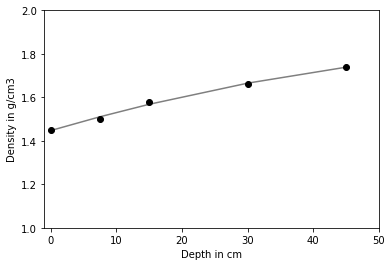

In [8]:
print('\033[1m'+'Density vs. Depth on the Moon'+'\033[0m')
print("(not implemented in the current model)")
plt.scatter(depth,density,color="black")
plt.plot(depth, fit(depth),color="black",alpha=0.5)
plt.xlabel("Depth in cm")
plt.ylabel("Density in g/cm3")

plt.xlim(-1, 50)
plt.ylim(1, 2)
plt.show()

In [9]:
print('\033[1m'+'Mode 1 metrics:'+'\033[0m')
print("Excavator mass:        ", round(MassEmpty + Cooling*MassFactorRadiator*1e-3,2), "kg")
print("Excavator power (avg.):", round(AveragePower,2), "W")
print("Cooling:               ", round(Cooling,2), "W")
print()
print("Trips per charge (%.0f m):               "%(DistanceISRU2Excavation + DistanceISRU2Disposal + DistanceDisposal2Excavation), RoverCyclesBeforeCharging, "(20 trips (200 m) for Schuler et al., 2019)")
print("Energy/Delivered Regolith (%.0f-m trips): %.2f Wh/kg"%(DistanceISRU2Excavation + DistanceISRU2Disposal + DistanceDisposal2Excavation, EnergyTotal/3600/RegolithCapacity), "(0.761 Wh/kg (200-m trips) for Schuler et al., 2019)")
print("Charging time per battery cycle:        ", TimeCharging,"h")
print()
print("Excavated mass per day (24 h):  ", MassPerDay, "kg")
print("Excavated volume per day (24 h):", VolumePerDay, "m3")

Mode 1 metrics:
Excavator mass:         86.34 kg
Excavator power (avg.): 117.98 W
Cooling:                257.92 W

Trips per charge (300 m):                9.0 (20 trips (200 m) for Schuler et al., 2019)
Energy/Delivered Regolith (300-m trips): 1.31 Wh/kg (0.761 Wh/kg (200-m trips) for Schuler et al., 2019)
Charging time per battery cycle:         5.64 h

Excavated mass per day (24 h):   2430.0 kg
Excavated volume per day (24 h): 1.62 m3


In [10]:
print('\033[1m'+'Mode 2 metrics:'+'\033[0m')
print(table)

Mode 2 metrics:
+-----+---------------+-------------------+-------------------------------+
| Day | Mass/Day (kg) | Average Power (W) | Energy/Delivered Mass (Wh/kg) |
+-----+---------------+-------------------+-------------------------------+
|  0  |     2430.0    |       133.04      |             1.314             |
|  1  |     2430.0    |       133.06      |             1.314             |
|  2  |     2430.0    |       133.08      |             1.314             |
|  3  |     2430.0    |       133.1       |             1.315             |
|  4  |     2430.0    |       133.12      |             1.315             |
|  5  |     2430.0    |       133.14      |             1.315             |
|  6  |     2430.0    |       133.15      |             1.315             |
|  7  |     2430.0    |       133.17      |             1.315             |
|  8  |     2430.0    |       133.19      |             1.315             |
|  9  |     2430.0    |       133.21      |             1.316           

## References

M.S. Anderson, M. Ewert, J. Keener, Life Support Baseline Values and Assumptions Document, Tech. Rep. NASA/TP-2015-218570, NASA, 2018, URL https://ntrs.nasa.gov/citations/20180001338

P.O. Hayne, J.L. Bandfield, M.A. Siegler, A.R. Vasavada, R.R. Ghent, J.-P. Williams, B.T. Greenhagen, O. Aharonson, C.M. Elder, P.G. Lucey, D.A. Paige, Global Regolith Thermophysical Properties of the Moon From the Diviner Lunar Radiometer Experiment, JGRPlanets 122 (12) (2017) 2371-2400, https://doi.org/10.1002/2017JE005387

G. Heiken, D. Vaniman, B.M. French, Lunar Sourcebook: A User’s Guide To the Moon, Cambridge University Press, 1991.

J.E. Kleinhenz, A. Paz, Case Studies for Lunar ISRU Systems Utilizing Polar Water, in ASCEND 2020, 2020, https://doi.org/10.2514/6.2020-4042

D.L. Linne, J.M. Schuler, L. Sibille, J.E. Kleinhenz, A.J. Colozza, H.J. Fincannon, S.R. Oleson, N.H. Suzuki, L. Moore, Lunar Production System for Extracting Oxygen from Regolith, Journal of Aerospace Engineering 34 (4) (2021) 04021043-1-13, https://doi.org/10.1061/(ASCE)AS.1943-5525.0001269

R.P. Mueller, J.D. Smith, J.M. Schuler, A.J. Nick, N.J. Gelino, K.W. Leucht, I.I. Townsend, A.G. Dokos, Design of an excavation robot: Regolith advanced surface systems operations robot (RASSOR) 2.0, in: Earth and Space 2016, American Society of Civil Engineers, Reston, VA, 2016, pp. 163–174, http://dx.doi.org/10.1061/9780784479971.018

J.M. Schuler, J.D. Smith, R.P. Mueller, and A.J. Nick, RASSOR, the reduced gravity excavator, in LUNAR ISRU 2019: Developing a New Space Economy, 2019, https://www.hou.usra.edu/meetings/lunarisru2019/pdf/5061.pdf

J.M. Schuler, A.J. Nick, K. Leucht, A. Langton, D. Smith, ISRU Pilot Excavator: Bucket Drum Scaling Experimental Results, in Earth and Space 2022, American Society of Civil Engineers, Denver, CO, 2023, https://doi.org/10.1061/9780784484470.037

S.S. Schreiner, J.A. Dominguez, L. Sibille, J.A. Hoffman, Thermophysical property models for lunar regolith, Adv. Space Res. 57 (5) (2016) 1209–1222, http://dx.doi.org/10.1016/j.asr.2015.12.035